# Race LSTM prediction
The aim of this notebook is to train a LSTM model being able to predict speed of the runner at the next data point.

In [58]:
### Load the dataset

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import dateutil.parser
from datetime import datetime

path = "../data/running/APE_running_data"

def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = datetime.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

colnames = np.array(['time', 'elevation', 'distance', 'speed'])
Datasets_all = []

os.chdir(path)
for file in glob.glob("*.tab"):
    print("Processing {}".format(file))
    dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
    dataset[:,0] -= dataset[0,0]
    dataset = pd.DataFrame(dataset,columns=colnames)
    slope = np.array([])
    window_size_half = 8
    for j in dataset.index:
        index = np.arange(j-window_size_half+1, j+window_size_half+1)
        index = index[(index >= 0) & (index < len(dataset))]
        dataset_part = dataset.iloc[index].dropna()
        regr = lm.LinearRegression()
        regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
        slope = np.append(slope,regr.coef_)
    dataset['slope'] = slope
    if (len(dataset) > 300) == (len(dataset) < 900):
        Datasets_all.append(dataset)


Processing activity_437398751.tab
Processing activity_437398728.tab
Processing activity_404227667.tab
Processing activity_437398762.tab
Processing activity_377304158.tab
Processing activity_447149230.tab
Processing activity_437398739.tab
Processing activity_437398771.tab
Processing activity_396872154.tab
Processing activity_447656990.tab
Processing activity_373735080.tab
Processing activity_373734948.tab
Processing activity_437398768.tab
Processing activity_437398746.tab
Processing activity_404227656.tab
Processing activity_437398721.tab
Processing activity_437398717.tab
Processing activity_437398782.tab
Processing activity_373735106.tab
Processing activity_437398753.tab
Processing activity_437398761.tab
Processing activity_377304230.tab
Processing activity_437398778.tab
Processing activity_437398785.tab
Processing activity_379843442.tab
Processing activity_404227695.tab
Processing activity_367230665.tab
Processing activity_447149252.tab
Processing activity_447149261.tab
Processing act

In [38]:
import numpy as np
from matplotlib import pyplot as pl

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils import np_utils

from sklearn import metrics as me

%matplotlib inline

Using TensorFlow backend.


In [32]:
LENGTH = 10
dataset = Datasets_all
seq = []
next_speed = []

len(dataset[0])

for i in range(len(dataset[0])-(LENGTH+1)):
    seq.append(dataset[0][i:i+LENGTH].as_matrix())
    next_speed.append(dataset[0][i+LENGTH:i+LENGTH+1]['speed'].as_matrix())

In [52]:
seq_test = []
next_speed_test = []

for i in range(len(dataset[1])-(LENGTH+1)):
    seq_test.append(dataset[1][i:i+LENGTH].as_matrix())
    next_speed_test.append(dataset[1][i+LENGTH:i+LENGTH+1]['speed'].as_matrix())
    
testX = np.array(seq_test)
testY = np.array(next_speed_test)

In [54]:
trainX = np.array(seq)
trainY = np.array(next_speed)

batch_size = 1
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(10, 5)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 4)                 160       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(trainX, trainY, epochs=15, batch_size=batch_size, verbose=1, 
                   validation_data=(testX, testY))

Train on 605 samples, validate on 714 samples
Epoch 1/25
605/605 [==============================] - 8s - loss: 5.2588 - val_loss: 2.0382
Epoch 2/25
605/605 [==============================] - 6s - loss: 1.5038 - val_loss: 0.7532
Epoch 3/25
605/605 [==============================] - 7s - loss: 0.6266 - val_loss: 0.8579
Epoch 4/25
605/605 [==============================] - 6s - loss: 0.4966 - val_loss: 0.9332
Epoch 5/25
605/605 [==============================] - 8s - loss: 0.4610 - val_loss: 0.9563
Epoch 6/25
605/605 [==============================] - 7s - loss: 0.4275 - val_loss: 0.9447
Epoch 7/25
605/605 [==============================] - 7s - loss: 0.3958 - val_loss: 0.9128
Epoch 8/25
605/605 [==============================] - 7s - loss: 0.3631 - val_loss: 0.8658
Epoch 9/25
605/605 [==============================] - 4s - loss: 0.3341 - val_loss: 0.8624
Epoch 10/25
605/605 [==============================] - 4s - loss: 0.3069 - val_loss: 0.8406
Epoch 11/25
605/605 [======================

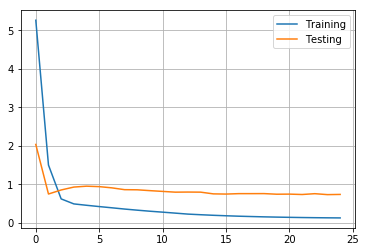

In [57]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

In [63]:
%load_ext version_information
%reload_ext version_information

%version_information numpy, matplotlib, keras, pandas

Software versions
Python 3.6.1 64bit [GCC 6.3.1 20170306]
IPython 6.0.0
OS Linux 4.10.13 1 ARCH x86_64 with arch
numpy 1.12.0
matplotlib 2.0.0
keras 2.0.3
pandas 0.19.2
Wed May 17 11:45:28 2017 CEST